# TCLab Historian

## Basic logging

The `tclab.Historian` class provides data logging. Given an instance of a TCLab object, an historian is created with the commands

    import tclab
    lab = tclab.TCLab()
    h = tclab.Historian(lab.sources)
    
The historian initializes a data log. The sources for the data log are specified in the argument to `tclab.Historian`. A default set of sources for an instance `lab` is given by `lab.sources`. The specification for sources is described in a later section.

The data log is updated by issuing a command

    h.update(t)
    
Where `t` is the current clock time. If `t` is omitted the historian will calculate its own time.

In [1]:
import tclab

TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    h = tclab.Historian(lab.sources)
    for t in tclab.clock(20):
        lab.Q1(100 if t <= 10 else 0)
        print("Time:", t, 'seconds')
        h.update(t)        

Simulated TCLab
Time: 0 seconds
Time: 1.0 seconds
Time: 2.0 seconds
Time: 3.1 seconds
Time: 4.0 seconds
Time: 5.0 seconds
Time: 6.0 seconds
Time: 7.0 seconds
Time: 8.0 seconds
Time: 9.0 seconds
Time: 10.0 seconds
Time: 11.0 seconds
Time: 12.0 seconds
Time: 13.0 seconds
Time: 14.0 seconds
Time: 15.0 seconds
Time: 16.0 seconds
Time: 17.0 seconds
Time: 18.0 seconds
Time: 19.0 seconds
Time: 20.0 seconds
TCLab Model disconnected successfully.


## Accessing the Data Log from the Historian

`Historian` maintains a data log that is updated on each encounter of the `.update()` function. The list of variables logged by an Historian is given by

In [2]:
h.columns

['Time', 'T1', 'T2', 'Q1', 'Q2']

Individual time series are available as elements of `Historian.fields`. For the default set of sources, the time series can be obtained as

    t, T1, T2, Q1, Q2 = h.fields 

For example, here's how to plot the history of temperature T1 versus time from the example above.

<IPython.core.display.Javascript object>


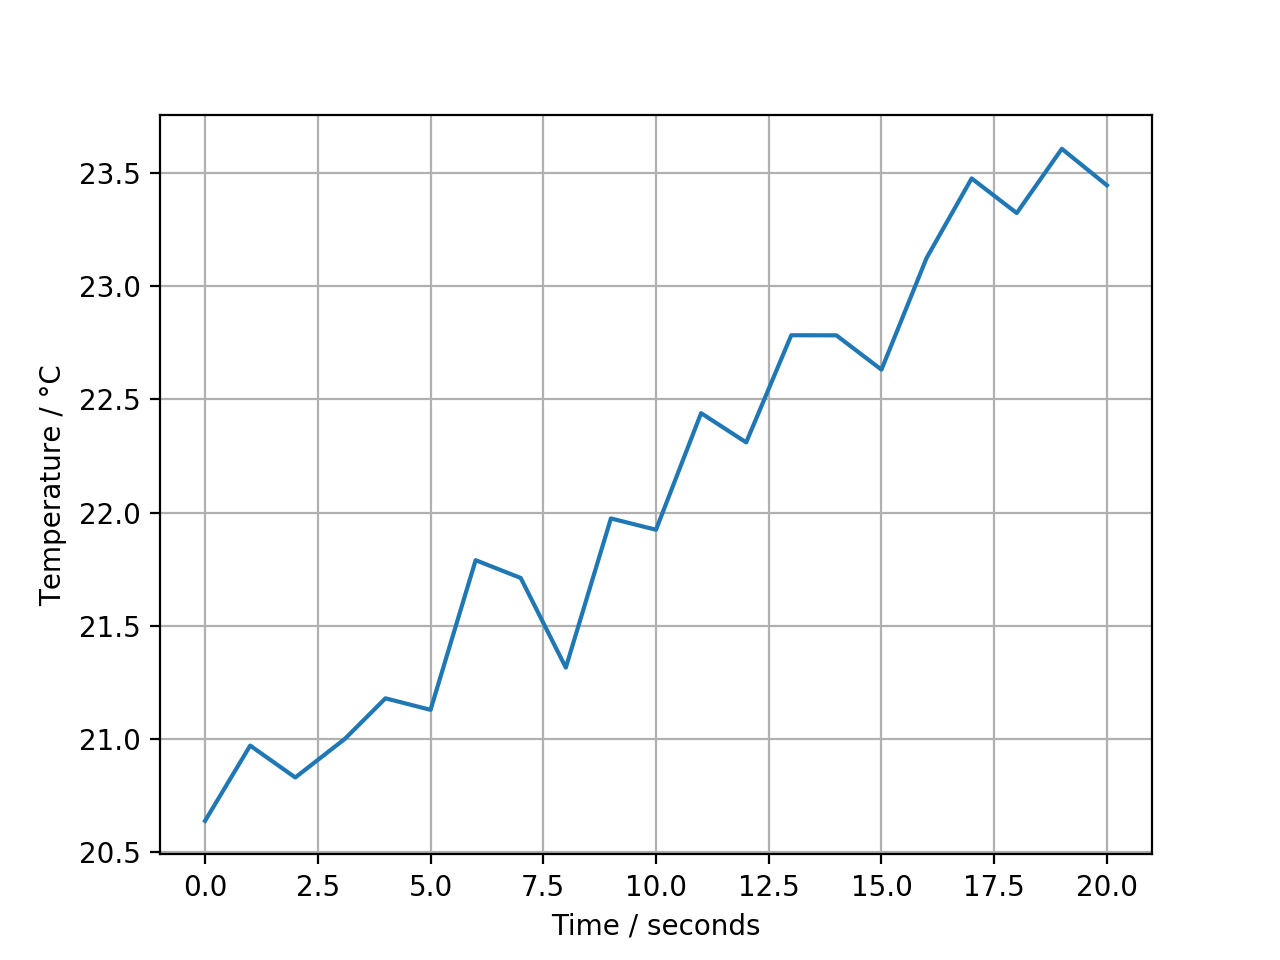

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt

t, T1, T2, Q1, Q2 = h.fields 
plt.plot(t, T1)
plt.xlabel('Time / seconds')
plt.ylabel('Temperature / °C')
plt.grid()

A sample code demonstrating how to plot the historian log.

<IPython.core.display.Javascript object>


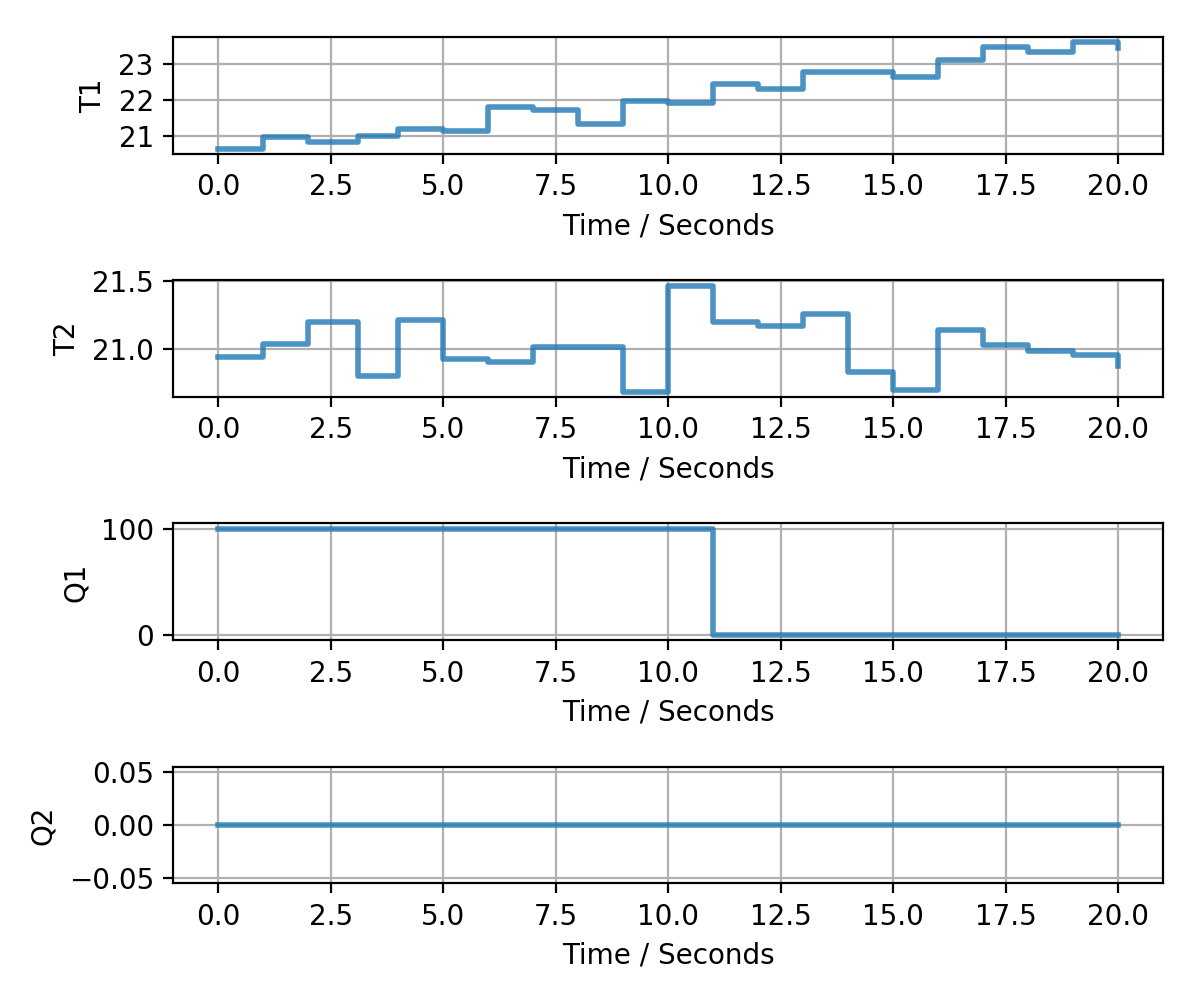

In [4]:
def plotlog(historian):
    line_options = {'lw': 2, 'alpha': 0.8}
    fig = plt.figure(figsize=(6, 5))
    nplots = len(h.columns) - 1
    t = historian.fields[0]
    for n in range(1, nplots+1):
        plt.subplot(nplots,1,n)
        y = historian.fields[n]
        plt.step(t, y, where='post', **line_options)          
        plt.grid()
        plt.xlabel('Time / Seconds')
        plt.ylabel(historian.columns[n])
    plt.tight_layout()
    
plotlog(h)

## Accessing log data using Pandas

Pandas is a widely use Python library for manipulation and analysis of data sets. Here we show how to access the `tclab.Historian` log using Pandas.

The entire data history is available from the historian as the attribute `.log`. Here we show the first three rows from the log:

In [5]:
h.log[:3]

[(0, 20.63764871669155, 20.943170851304753, 100, 0),
 (1.0, 20.970051008953146, 21.039093002960875, 100, 0),
 (2.0, 20.82904255696425, 21.19942260552886, 100, 0)]

The log can be converted to a Pandas dataframe.

In [6]:
import pandas as pd

df = pd.DataFrame.from_records(h.log, columns=h.columns, index='Time')
df.head()

,T1,T2,Q1,Q2
Time,,,,
0.0,20.637649,20.943171,100,0
1.0,20.970051,21.039093,100,0
2.0,20.829043,21.199423,100,0
3.1,20.999762,20.804944,100,0
4.0,21.178955,21.211932,100,0


The following cells provide examples of plots that can be constructed once the data log has been converted to a pandas dataframe.

<IPython.core.display.Javascript object>


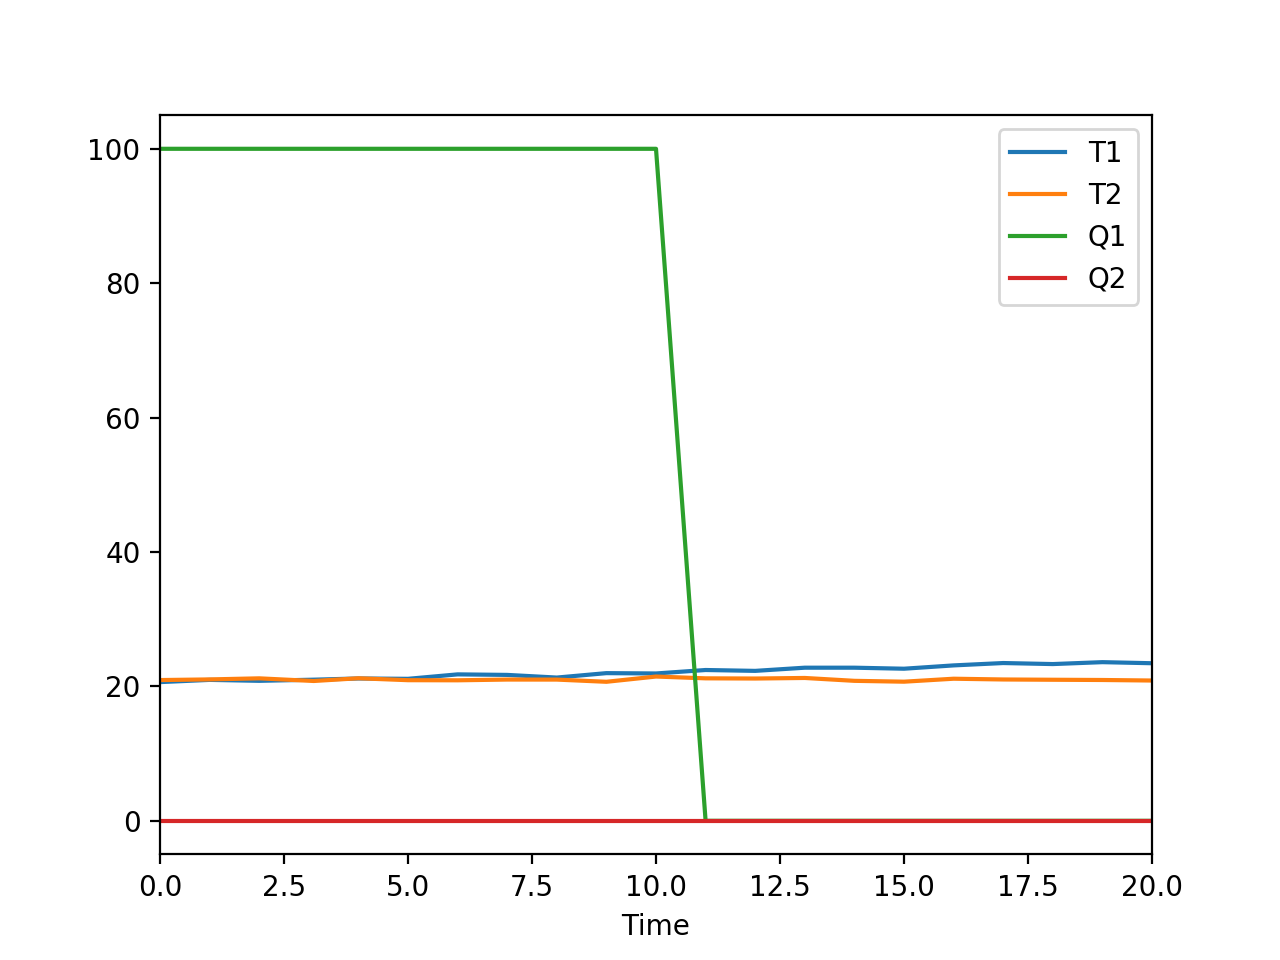

In [7]:
df.plot()

<IPython.core.display.Javascript object>


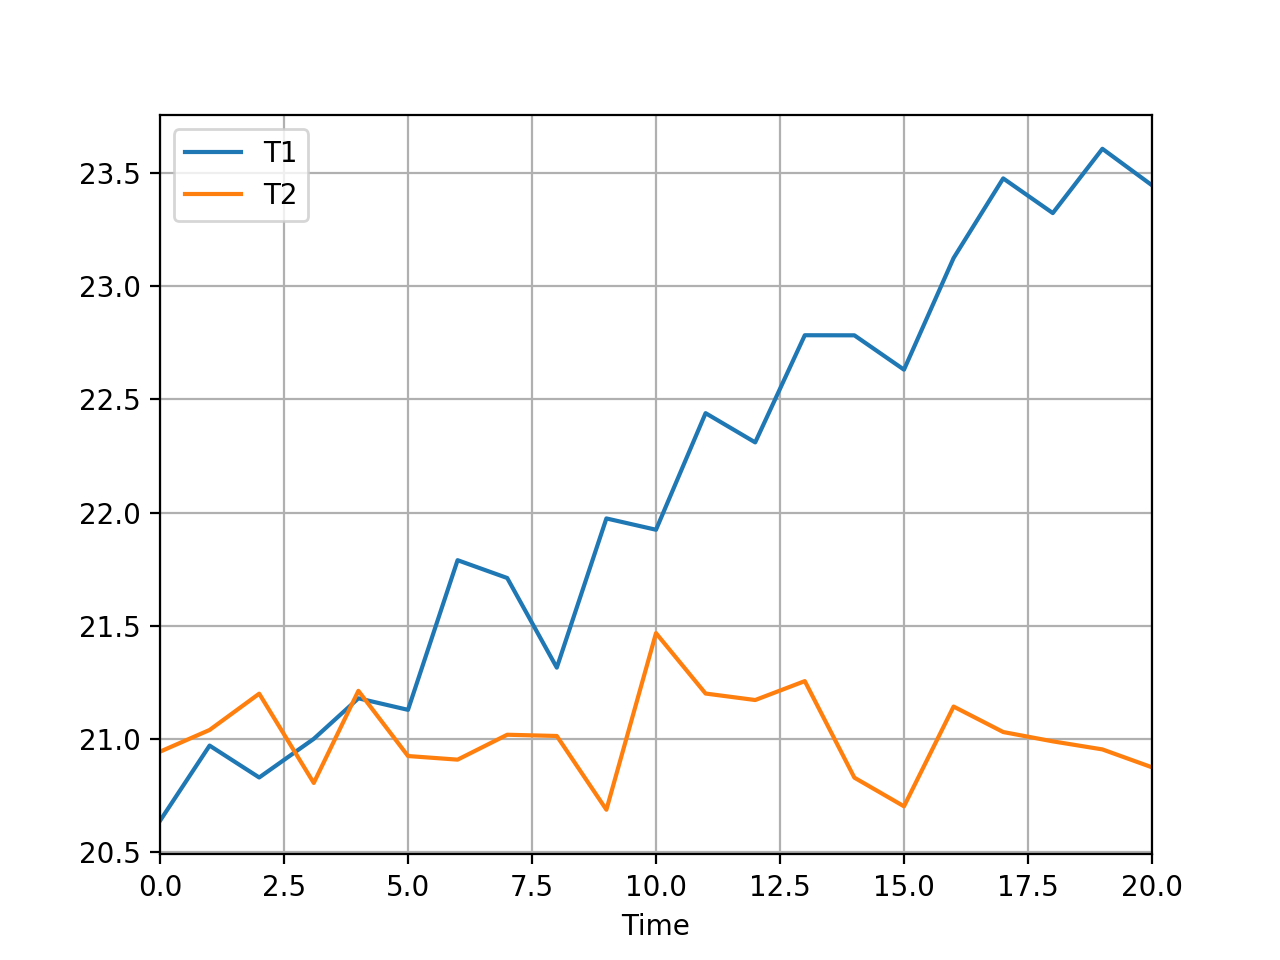

In [8]:
df[['T1','T2']].plot(grid=True)

## Specifying Sources for `tclab.Historian`

To create an instance of `tclab.Historian`, a set of sources needs to be specified. For many cases the default sources created for an instance of `TCLab` is sufficient. However, it is possible to specify additional sources which can be useful when implementing more complex algorithms for process control.

`sources` is specified as a list of tuples. Each tuple as two elements. The first element is a label for the source. The second element is a function that returns a value.

The following cell shows how to create a source with the label `Power` with a value equal to the estimated heater power measured in watts. This is created on the assumption that 100% of a maximum power of 200 corresponds to 4.2 watts.

In [9]:
import tclab

TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [
        ('T1', lambda: lab.T1),
        ('Power', lambda: lab.P1*lab.U1*4.2/(200*100))        
    ]
    h = tclab.Historian(sources)
    for t in tclab.clock(20):
        lab.Q1(100 if t <= 10 else 0)
        print("Time:", t, 'seconds')
        h.update(t)        

Simulated TCLab
Time: 0 seconds
Time: 1.0 seconds
Time: 2.0 seconds
Time: 3.1 seconds
Time: 4.1 seconds
Time: 5.1 seconds
Time: 6.0 seconds
Time: 7.0 seconds
Time: 8.0 seconds
Time: 9.0 seconds
Time: 10.0 seconds
Time: 11.0 seconds
Time: 12.0 seconds
Time: 13.0 seconds
Time: 14.0 seconds
Time: 15.1 seconds
Time: 16.1 seconds
Time: 17.0 seconds
Time: 18.1 seconds
Time: 19.0 seconds
Time: 20.1 seconds
TCLab Model disconnected successfully.


In [10]:
import pandas as pd

df = pd.DataFrame.from_records(h.log, columns=h.columns, index='Time')
df.head()

,T1,Power
Time,,
0.0,21.122906,4.2
1.0,21.042728,4.2
2.0,21.089869,4.2
3.1,20.735415,4.2
4.1,21.247619,4.2


### Functions with multiple returns

In some cases it is easier to calculate a number of different variables to be logged in one function, especially if intermediate results are used in following calculations. This can be accommodated by `Historian` by passing `None` as the function for subsequent values if a previous value returned a list of values.

In [11]:
import tclab

TCLab = tclab.setup(connected=False, speedup=10)

def log_values():
    T1 = lab.T1
    T1Kelvin = T1 + 273.15
    power = lab.P1*lab.U1*4.2/(200*100)
    return T1, T1Kelvin, power

with TCLab() as lab:
    h = tclab.Historian([('T1', log_values),
                         ('T1Kelvin', None),
                         ('Power', None)])
    for t in tclab.clock(20):
        lab.Q1(100 if t <= 10 else 0)
        print("Time:", t, 'seconds')
        h.update(t)        

Simulated TCLab
Time: 0 seconds
Time: 1.1 seconds
Time: 2.0 seconds
Time: 3.0 seconds
Time: 4.1 seconds
Time: 5.0 seconds
Time: 6.1 seconds
Time: 7.1 seconds
Time: 8.1 seconds
Time: 9.0 seconds
Time: 10.1 seconds
Time: 11.1 seconds
Time: 12.1 seconds
Time: 13.1 seconds
Time: 14.1 seconds
Time: 15.1 seconds
Time: 16.0 seconds
Time: 17.1 seconds
Time: 18.0 seconds
Time: 19.0 seconds
Time: 20.1 seconds
TCLab Model disconnected successfully.


In [12]:
import pandas as pd

df = pd.DataFrame.from_records(h.log, columns=h.columns, index='Time')
df.head()

,T1,T1Kelvin,Power
Time,,,
0.0,21.398474,294.548474,4.2
1.1,20.896188,294.046188,4.2
2.0,21.020920,294.170920,4.2
3.0,21.388696,294.538696,4.2
4.1,21.422918,294.572918,4.2


In [13]:
h.log

[(0, 21.39847390202538, 294.54847390202536, 4.2),
 (1.1, 20.896188106048534, 294.04618810604853, 4.2),
 (2.0, 21.020919672793628, 294.1709196727936, 4.2),
 (3.0, 21.388695634608457, 294.5386956346084, 4.2),
 (4.1, 21.422917556207384, 294.57291755620736, 4.2),
 (5.0, 21.280749815780343, 294.4307498157803, 4.2),
 (6.1, 21.21011564474363, 294.3601156447436, 4.2),
 (7.1, 21.432219179442992, 294.582219179443, 4.2),
 (8.1, 21.338012494864614, 294.4880124948646, 4.2),
 (9.0, 21.723905963683276, 294.8739059636832, 4.2),
 (10.1, 22.016211560264587, 295.16621156026457, 0.0),
 (11.1, 21.890799258407608, 295.04079925840756, 0.0),
 (12.1, 22.362670233474688, 295.51267023347464, 0.0),
 (13.1, 22.33554429445724, 295.4855442944572, 0.0),
 (14.1, 22.801111360426944, 295.9511113604269, 0.0),
 (15.1, 22.663066304511183, 295.81306630451115, 0.0),
 (16.0, 22.797209805678705, 295.94720980567865, 0.0),
 (17.1, 23.24049659958222, 296.3904965995822, 0.0),
 (18.0, 22.747918305203207, 295.8979183052032, 0.0),
 (

## Sessions

It is possible to run multiple experiments using the same `Historian` and page back to them after running them:

In [2]:
import tclab

TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    h = tclab.Historian(lab.sources)
    for t in tclab.clock(20):
        lab.Q1(100 if t <= 10 else 0)
        h.update(t)
    h.new_session()
    for t in tclab.clock(20):
        lab.Q1(0 if t <= 10 else 100)
        h.update(t)    

Simulated TCLab
TCLab Model disconnected successfully.


To see the stored sessions, use `get_sessions`:

In [6]:
h.get_sessions()

[(1, '2018-02-18 17:00:41'), (2, '2018-02-18 17:00:43')]

The historian log shows the data for the last session, where the heater started open

In [12]:
h.log[:2]

[(0, 20.90865374061689, 20.89324077368182, 100, 0),
 (1.0, 20.754672349149576, 20.91112483321418, 100, 0)]

To roll back to a different session, use `load_session()`:

In [13]:
h.load_session(1)

In [14]:
h.log[:2]

[(0, 20.90865374061689, 20.89324077368182, 100, 0),
 (1.0, 20.754672349149576, 20.91112483321418, 100, 0)]

## Persistence

`Historian` stores results in a [SQLite](https://www.sqlite.org/) database. By default, it uses the special file `:memory:` which means the results are lost when you shut down or restart the kernel. To retain values across runs, you can specify a filename (by convention SQLite databases have the `.db` extension).

In [15]:
import tclab

TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    h = tclab.Historian(lab.sources, dbfile='test.db')
    for t in tclab.clock(20):
        lab.Q1(100 if t <= 10 else 0)
        h.update(t)

Simulated TCLab
TCLab Model disconnected successfully.


Every time you run this cell, new sessions will be added to the file. These sessions can be loaded as shown in the Sessions section above. There is currently no support for managing sessions. If you want to remove the old sessions, delete the database file.